# Navigation with Deep-Q Network algorithm

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
from dqn_agent import Agent
import time
import matplotlib.pyplot as plt
import pandas as pd

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
filename = "../Banana_Windows_x86_64/Banana.exe"
env = UnityEnvironment(file_name=filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]

### 2. Train DQN Agent

In [4]:
def dqn(agent, env, brain_name, max_n_episodes=2000, max_n_steps=1000,
        epsilon_start=1.0, epsilon_min=0.01, epsilon_decay_rate=0.995):
    """Deep Q-Learning Agent.
    
    Parameters
    ----------
        max_n_episodes : int
            Maximum number of training episodes
        max_n_steps : int
            Maximum number of steps per episode
        epsilon_start : float
            Starting value of epsilon, for epsilon-greedy action selection
        epsilon_min : float)
            Minimum value of epsilon
        epsilon_decay_rate : float
            Multiplicative factor (per episode) for decreasing epsilon
    """
    all_scores = []                      # list of scores from all episodes
    last_100_scores = deque(maxlen=100)  # last 100 scores
    epsilon = epsilon_start              # initialize epsilon
    # loop through episodes
    is_game_over = False
    episode_count = 1
    while not is_game_over:
        # observe state and initialize score
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        # loop through steps within each episode
        is_episode_over = False
        step_count = 1
        while not is_episode_over:
            # pick action
            action = agent.act(state, epsilon)
            # observe updated environment, reward and next state
            updated_env = env.step(action)[brain_name]
            next_state = updated_env.vector_observations[0]
            reward = updated_env.rewards[0]
            is_episode_over = updated_env.local_done[0]
            # update next state and add reward from step to episode score
            agent.step(state, action, reward, next_state, is_episode_over)
            state = next_state
            score += reward
            # if episode is over or max_n_steps reached, end loop
            # otherwise, do one more step
            is_episode_over = is_episode_over or (step_count >= max_n_steps)
            step_count += 1
        # anneal epsilon
        epsilon = max(epsilon_min, epsilon_decay_rate*epsilon)
        # keep track of most recent score
        last_100_scores.append(score)
        all_scores.append(score)
        last_100_scores_mean = np.mean(last_100_scores)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, last_100_scores_mean), end="")
        completed_100_episodes = episode_count % 100 == 0
        if completed_100_episodes:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, last_100_scores_mean))
        is_problem_solved = last_100_scores_mean >= 13.0
        if is_problem_solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'\
                  .format(episode_count, last_100_scores_mean))
            torch.save(agent.qnetwork_local.state_dict(), 'weights.pth')
        # if problem solved or max_n_episodes reached, end loop
        # otherwise, play one more episode
        is_game_over = is_problem_solved or (episode_count >= max_n_episodes)
        episode_count += 1
    return all_scores

In [5]:
# initialize agent
agent = Agent(state_size=37, action_size=4, seed=0)
brain_name = env.brain_names[0]

# track start time
start_time = time.time()

# train DQN agent
scores = dqn(agent, env, brain_name)

# track end time and print training time
end_time = time.time()
training_time = round((end_time - start_time) / 60, 1)
print('Total training time: {} minutes'.format(training_time))

Episode 100	Average Score: 0.54
Episode 200	Average Score: 3.77
Episode 300	Average Score: 7.06
Episode 400	Average Score: 9.61
Episode 500	Average Score: 12.88
Episode 535	Average Score: 13.00
Environment solved in 535 episodes!	Average Score: 13.00
Total training time: 25.0 minutes


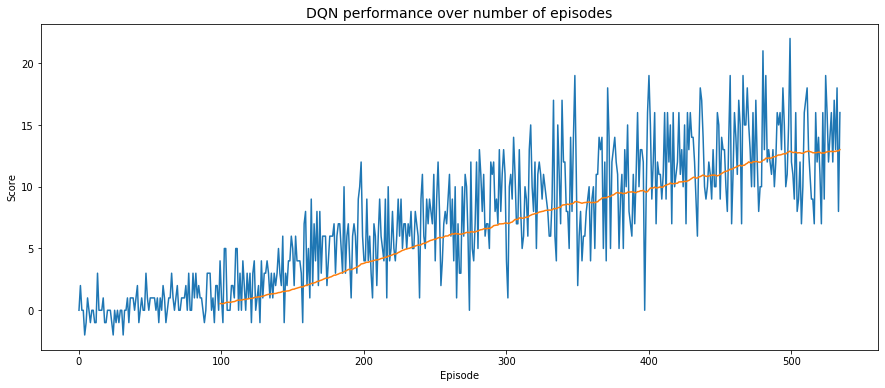

In [7]:
# plot performance
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
# plot scores for all episodes
scores_idx = np.arange(len(scores))
plt.plot(scores_idx, scores)
# plot moving average of last 100 scores for smoother plotting
scores_moving_avg = pd.Series(scores).rolling(100).mean()
plt.plot(scores_idx, scores_moving_avg)
plt.title('DQN performance over number of episodes', size=14)
# plt.title('DQN  Performance Over Number of Episodes')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()